In [1]:

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from baum_welch_jax import HiddenMarkovParameters, forward_backward, generate_sequence

from plotting import plot_hmm_params


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

# Forward-Backward

This notebook shows the usage of `forward_backward` to obtain an estimate of the state distribution given a sequence of observations. First we define a set of parameters:

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


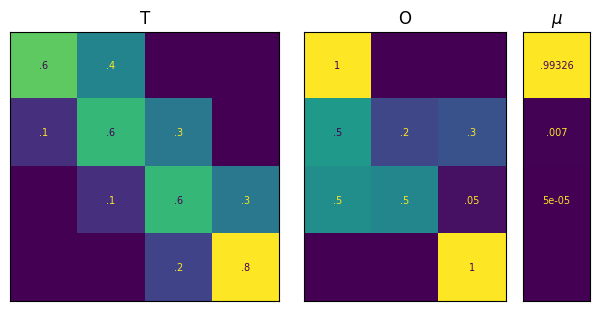

In [2]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jax.random.key(seed)
key, O_key, mu_key = jax.random.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.5 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.3 * jnp.eye(n, k=1)
T = T + 0.1 * jnp.eye(n, k=-1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jax.random.uniform(O_key, (n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

hmm = HiddenMarkovParameters(T, O, mu)

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

fig, ax =plot_hmm_params(hmm, with_numbers=True)
fig.set_size_inches(6,3)
plt.show()

Let's do a quick sanity check of the implementations, do they match up?

In [3]:
states, observations = generate_sequence(jax.random.key(0), hmm, length=100)

gamma, xi = forward_backward(observations, hmm, mode='regular')
gamma_log, xi_log = forward_backward(observations, hmm, mode='log')

print("Results match for gamma:", jnp.allclose(jnp.exp(gamma_log), gamma))
print("Results match for xi:", jnp.allclose(jnp.exp(xi_log), xi))

Results match for gamma: True
Results match for xi: True


Note that we can normalize the rows of the matrix `gamma` to obtain the unnormalized conditional distributions $$\mathbb{P}[s_t = k | o_{1:n}].$$
We can compare them to estimates of the distributions based on sampled sequences:

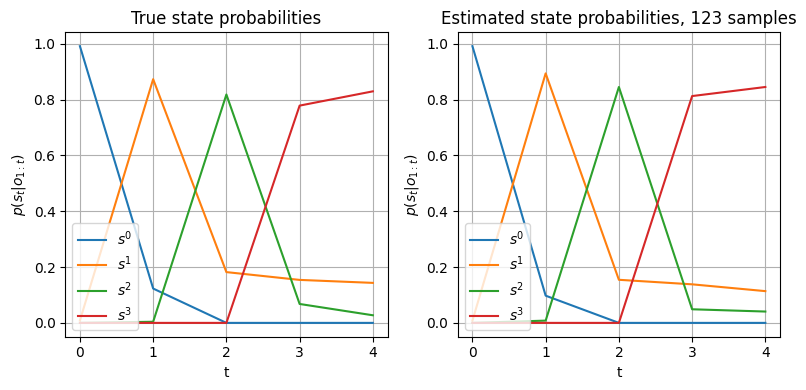

In [4]:
n_sequences = 10_000
test_length = 5

keys = jnp.array(jax.random.split(jax.random.key(0), n_sequences))
states, observations = jax.vmap(lambda _key: generate_sequence(_key, hmm, length=test_length))(keys)


test_sequence = observations[0, :test_length]
gamma, xi = forward_backward(test_sequence, hmm, mode='regular')

# For each step t, contains the probability of being in a given state at step
state_distributions = (gamma / jnp.sum(gamma, axis=-1)[:, None])

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8,4)

for k, row in enumerate(state_distributions.T):
    ax[0].plot(row, label=f"$s^{k}$")
ax[0].set_title("True state probabilities")

# Collect all sample sequences that are identical with the test sequence to estimate the 
# conditional probabilities of the states!
identical_indices = jnp.all(observations[:, :test_length] == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

# Take all the relevant state sequences
filtered_states = states[identical_indices]

# Estimate the state distribution from them numerically
state_distr = jax.lax.map(
    lambda s: jnp.count_nonzero(filtered_states == s, axis=0), 
    jnp.arange(n)
    ) / filtered_states.shape[0]

# Compare both the estimated distribution and the one computed from the parameters
for k, row in enumerate(state_distr):
    ax[1].plot(row[:test_length], label=f"$s^{k}$")
ax[1].set_title("Estimated state probabilities" + f", {len(filtered_states)} samples")

for k in (0,1):
    ax[k].set_xlabel("t")
    ax[k].set_ylabel("$p(s_t | o_{1:t})$")
    ax[k].grid()
    ax[k].legend(loc="lower left")

plt.tight_layout()
plt.show()